# Project - Classification of Breast Ultrasound Images
This is a message about the project work you will be doing as a group (Group 3). Each group will be given a medical image dataset focusing on a specific disease. In your case, the dataset is a compilation of ultrasound images of healthy, benign and malignant breast tissue. Your task is to train a model and evaluate it on the test data. The ultrasound images are not categorized into train/test sets, so you need to divide the data into train/test categories with a ratio of 70 (train)/30(test). You will also have to prepare a 15-20 minute presentation on the model you have trained, the results of your model and the interpretation of the results. You have two weeks to complete the project. We are planning for you to give the presentation on 15 May.
The image dataset can be found at [here](https://www.dropbox.com/s/msewflgcj1la9sj/3_ultra_sound_data.zip?dl=0)

## Select Device

In [24]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [25]:
from torch.utils.data import Dataset, random_split
from tqdm import tqdm
from skimage import io
from torchvision import transforms

dataset_path = "./data/dataset.pt"
raw_data_dir = "./data/3_ultra_sound_data/Breast Ultrasound Images Dataset"


# Define the dataset class
class BreastDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.labels = []
        self.masks = []

        self.transform = transform

        self.load_images(os.path.join(data_dir, "normal"), 0)
        self.load_images(os.path.join(data_dir, "benign"), 1)
        self.load_images(os.path.join(data_dir, "malignant"), 2)

        # Save dataset
        torch.save(self, dataset_path)

    def load_images(self, dir_path, label):
        for filename in tqdm(os.listdir(dir_path)):
            if filename.endswith(".png") and "mask" not in filename:
                img_path = os.path.join(dir_path, filename)
                img = io.imread(img_path)
                self.images.append(img)

                mask_path = os.path.splitext(img_path)[0] + "_mask.png"
                mask = io.imread(mask_path)
                self.masks.append(mask)

                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.transform is not None:
            return (self.transform(self.images[idx]), self.labels[idx])
        else:
            return (
                self.images[idx],
                self.labels[idx],
                self.masks[idx],
            )


# Define transforms for data preprocessing
data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(224),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset = (
    torch.load(dataset_path)
    if os.path.isfile(dataset_path)
    else BreastDataset(raw_data_dir, transform=data_transforms)
)

# Define the sizes of the training, validation, and test sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

# Use random_split to split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

label_names = ["Normal", "Benign", "Malignant"]

100%|██████████| 421/421 [00:02<00:00, 189.44it/s]


## Display Samples

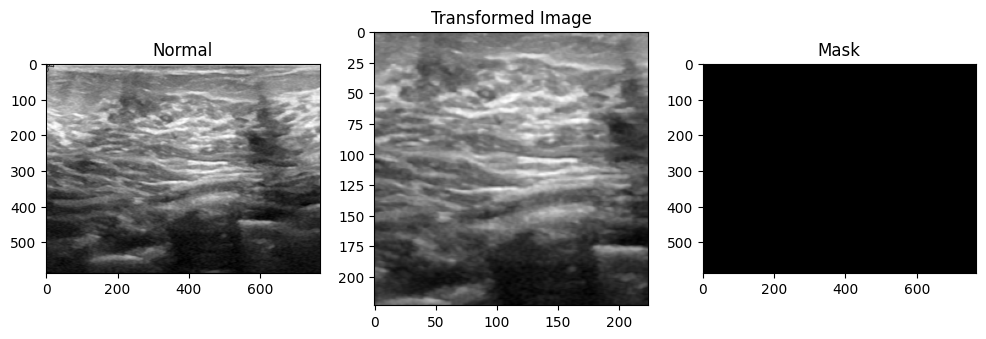

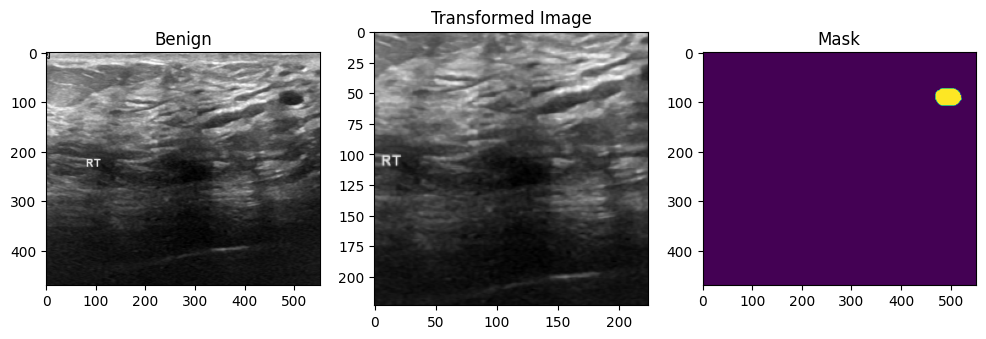

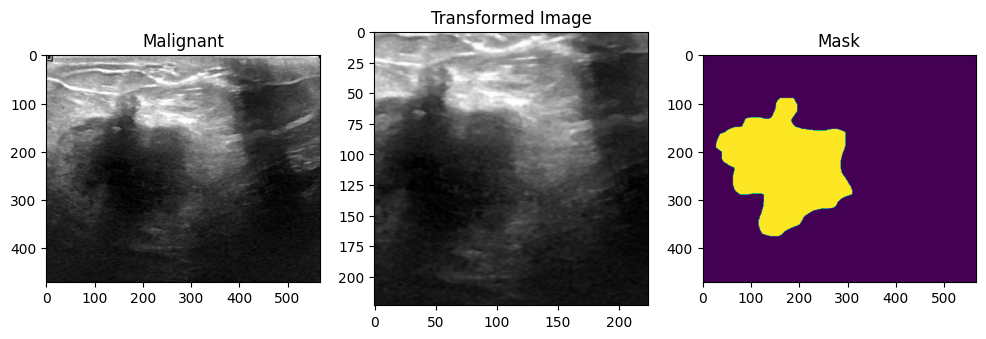

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors


def plot_image(org_img, trans_img, lbl, mask):
    # Create a figure with two subplots
    fig, axes = plt.subplots(ncols=3)
    fig.set_size_inches(12, 6)

    # Display the original image in the second subplot
    axes[0].imshow(org_img)
    axes[0].set_title(label_names[lbl])

    # normalize the image values to be within [0,1]
    norm = colors.Normalize(vmin=trans_img.min(), vmax=trans_img.max())
    trans_img = norm(trans_img)
    # Display the transformed image in the second subplot
    axes[1].imshow(np.transpose(trans_img, (1, 2, 0)))
    axes[1].set_title("Transformed Image")

    # Display the mask in the third subplot
    axes[2].imshow(mask)
    axes[2].set_title("Mask")

    # Show the figure
    plt.show()


def plot_sample(data, label):
    trans = data.dataset.transform
    for i in range(len(data)):
        data.dataset.transform = None
        org_img, lbl, mask = data[i]
        data.dataset.transform = trans
        trans_img, _ = data[i]
        if lbl == label:
            plot_image(org_img, trans_img, lbl, mask)
            break


plot_sample(train_dataset, 0)
plot_sample(train_dataset, 1)
plot_sample(train_dataset, 2)

## Data Exploration

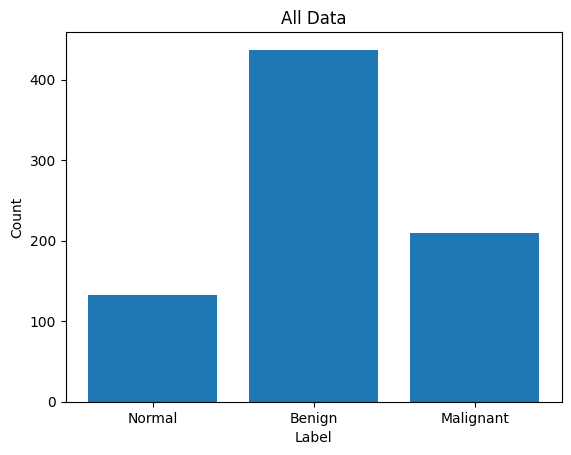

{'Normal': 133, 'Benign': 437, 'Malignant': 210}





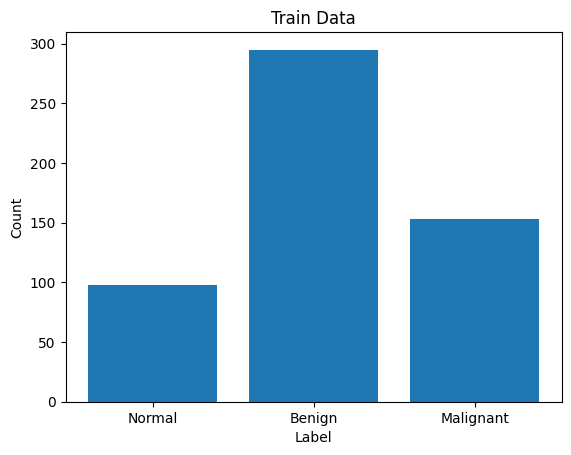

{'Normal': 98, 'Benign': 295, 'Malignant': 153}





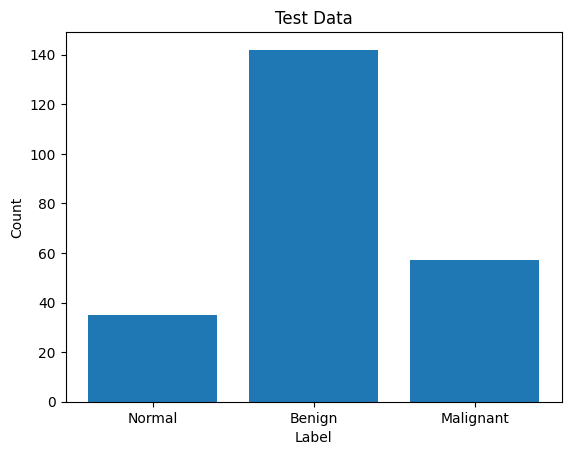

{'Normal': 35, 'Benign': 142, 'Malignant': 57}





{'Normal': 35, 'Benign': 142, 'Malignant': 57}

In [67]:
def data_stats(data, title):
    label_counts = {}
    for label_name in label_names:
        label_counts[label_name] = 0

    for i in range(len(data)):
        _, lbl = data[i]
        label_name = label_names[lbl]
        label_counts[label_name] += 1

    # Extract the counts and labels as separate lists
    counts = list(label_counts.values())
    labels = list(label_counts.keys())

    # Create a bar chart using matplotlib
    plt.bar(labels, counts)

    # Add axis labels and a title
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(title)

    # Display the chart
    plt.show()
    print(label_counts)
    print("\n\n")

    return label_counts


label_counts = data_stats(dataset, "All Data")
data_stats(train_dataset, "Train Data")
data_stats(test_dataset, "Test Data")

## Data Augmentation
Since we have few an unbalanced dataset we need some kind of data augmentation. This is from the [Paper](./data/3_ultra_sound_data/Paper_79-Deep_Learning_Approaches_for_Data_Augmentation.pdf):

While augmentation most certainly helps neural networks learn and generalize more effectively, it also has its drawbacks. In most cases, augmentation techniques are limited to minor changes on an image, as more “heavy” augmentations might damage the image’s semantic content. Furthermore, the forms of augmentation one can use differ from problem to problem, making their application ad-hoc and empirical. For instance, medical images have to be mildly augmented as they follow strict standards (i.e., they are centered, their orientation and intensity vary little from image to image and many times they are laterally/horizontally asymmetric) [12]. Finally, augmentation techniques are applied to one image at a time and thus are unable to gather any information from the rest of the dataset.

## Choose of Classifier
The paper uses AlexNet. I asked Chat-GPT if there is a better alternative for AlexNet? And here is its answer:

Transfer learning can be a powerful technique for building image classifiers, and using a pre-trained model like AlexNet can be a good starting point for building a breast cancer detection model. However, there may be better alternatives to AlexNet depending on the specific characteristics of your dataset and the problem you are trying to solve.

One alternative to AlexNet is ResNet (Residual Network), which has shown to be effective in a variety of image classification tasks, including medical image analysis. ResNet is a deeper neural network architecture than AlexNet, which may allow it to capture more complex features in the breast ultrasound images.

Another alternative is Inception-v3, which uses a multi-branch architecture to capture features at different scales. This can be useful for detecting subtle variations in the breast tissue that may be indicative of cancer.

There are also newer architectures, such as EfficientNet and Vision Transformer (ViT), that have shown strong performance on image classification tasks, including medical image analysis. EfficientNet is designed to be more computationally efficient while still achieving high accuracy, while ViT is based on a self-attention mechanism that can capture long-range dependencies between features.

In summary, there are many options for neural network architectures that can be used for breast cancer detection in ultrasound images. It is important to experiment with different architectures to find the one that works best for your specific dataset and problem.

So far we have 5 options for the classifier model:
1. AlexNet
2. ResNet
3. Inception-v3
4. EfficientNet
5. Vision Transformer (ViT)

ALso, we need to decide if we want to apply data augmentation or not. There are two options for data augmentation:
1. Classical simple methods
2. Modern and complex method of using GANs

We can choose between these options and assign them to each other. What do you think?

## ResNet

In [70]:
from torchvision.models.resnet import resnet18, ResNet18_Weights
from torchvision import transforms

res_net = resnet18(weights=ResNet18_Weights.DEFAULT)

print(res_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Replace last layer
last_in_features_count = res_net.fc.in_features
res_net.fc = nn.Linear(last_in_features_count, 3)
res_net = res_net.to(device)

# Define the loss function
class_weight = torch.FloatTensor(
    [
        label_counts[label_names[0]],
        label_counts[label_names[1]],
        label_counts[label_names[2]],
    ]
)
criterion = nn.CrossEntropyLoss(weight=class_weight)

criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(res_net.parameters(), lr=0.0001)


# Train the model
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(loader)
    train_acc = 100.0 * correct / total

    return train_loss, train_acc


# Evaluate the model
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(loader)
    test_acc = 100.0 * correct / total

    return test_loss, test_acc


# Train and evaluate the model
best_test_acc = 0

for epoch in range(100):
    train_loss, train_acc = train(res_net, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(res_net, test_loader, criterion, device)

    # Save the best trained model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(res_net, "res_net.pth")

    print(
        f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%"
    )

print(f"Best Test Acc: {best_test_acc:.2f}%")

Epoch 1: Train Loss: 0.7595 | Train Acc: 65.93% | Test Loss: 0.5977 | Test Acc: 72.22%
Epoch 2: Train Loss: 0.1802 | Train Acc: 97.44% | Test Loss: 0.5505 | Test Acc: 80.34%
Epoch 3: Train Loss: 0.0591 | Train Acc: 99.63% | Test Loss: 0.5363 | Test Acc: 79.91%
Epoch 4: Train Loss: 0.0379 | Train Acc: 99.82% | Test Loss: 0.6254 | Test Acc: 77.35%
Epoch 5: Train Loss: 0.1450 | Train Acc: 99.63% | Test Loss: 0.5650 | Test Acc: 79.49%
Epoch 6: Train Loss: 0.0462 | Train Acc: 99.63% | Test Loss: 0.6015 | Test Acc: 76.92%
Epoch 7: Train Loss: 0.0190 | Train Acc: 99.82% | Test Loss: 0.5682 | Test Acc: 79.91%
Epoch 8: Train Loss: 0.1319 | Train Acc: 99.63% | Test Loss: 0.6516 | Test Acc: 79.06%
Epoch 9: Train Loss: 0.1108 | Train Acc: 98.90% | Test Loss: 0.6678 | Test Acc: 78.63%
Epoch 10: Train Loss: 0.0815 | Train Acc: 98.72% | Test Loss: 0.7049 | Test Acc: 76.50%
Epoch 11: Train Loss: 0.0557 | Train Acc: 99.63% | Test Loss: 0.6771 | Test Acc: 79.49%
Epoch 12: Train Loss: 0.1624 | Train Acc:

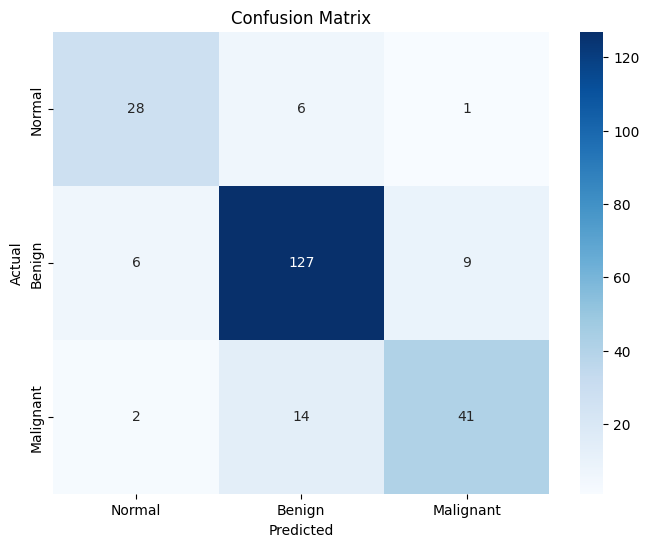

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted labels and ground truth labels for the test set
all_predicted_labels = []
all_ground_truth_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = res_net(inputs)
        _, predicted = outputs.max(1)
        all_predicted_labels += predicted.tolist()
        all_ground_truth_labels += labels.tolist()

# Compute the confusion matrix
cm = confusion_matrix(all_ground_truth_labels, all_predicted_labels)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
plt.show()

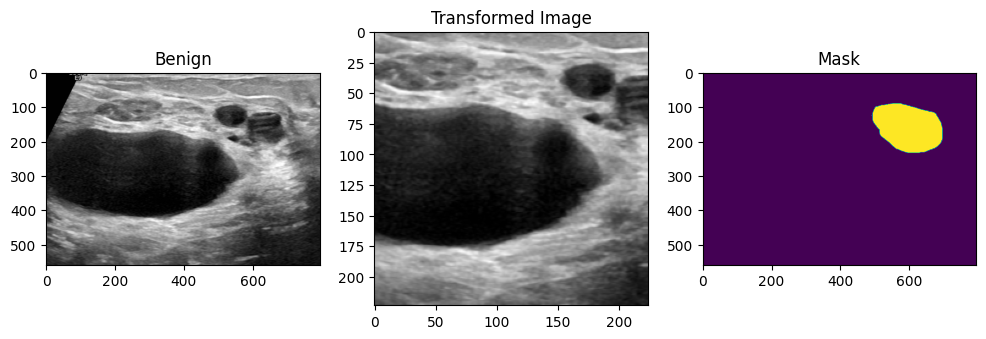

Benign


In [77]:
data_index = 15
trans = dataset.transform
dataset.transform = None
org_img, lbl, mask = test_dataset[data_index]
dataset.transform = trans
trans_img, _ = test_dataset[data_index]

plot_image(org_img, trans_img, lbl, mask)
output = res_net(trans_img.view(1, *trans_img.shape).to(device))
_, predicted = output.max(1)
class_name = label_names[predicted]
print(class_name)